In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
import math
import os


#path = 'e:\\Data\\spray\\simulation\\'
#path = 'e:\\Data\\spray\\CFD_Simulations\\ExampleDataCFD_20180326\\'
#path = 'e:\\Data\\spray\\CFD_Simulations\\MeshStudyBox_20180518\\'
path = 'e:\\Data\\spray\\CFD_Simulations\\stats_4data_box1p00\\'

#dataset = 'box1p00
dataset = 'frame04'
#%%

#df = pd.read_csv(path + 'frame04.csv')
df = pd.read_csv(path + dataset + '.csv')

print(df.columns.values)

['Density' 'Liq_Mass_Frac' 'Liq_Vol_Frac' 'StatsVelocityXMean'
 'StatsVelocityYMean' 'StatsVelocityZMean' 'vtkValidPointMask'
 'vtkGhostType']


In [24]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [25]:
#print df 
d = df['Density'].values
liq_mass_frac = df['Liq_Mass_Frac'].values
liq_vol_frac = df['Liq_Vol_Frac'].values

u = df['StatsVelocityXMean'].values
v = df['StatsVelocityYMean'].values
w = df['StatsVelocityZMean'].values

nx = 251
ny = 251
nz = 251

print(len(d))
print(nx*ny*nz)

print(np.min(d))
print(np.max(d))


vol = d.reshape((nz, ny, nx))
u = u.reshape((nz, ny, nx))
v = v.reshape((nz, ny, nx))
w = w.reshape((nz, ny, nx))

liq_mass_frac = liq_mass_frac.reshape((nz, ny, nx)) 
liq_vol_frac = liq_vol_frac.reshape((nz, ny, nx)) 

amp = np.sqrt(u*u +v*v + w*w)

#print vol[25]

print('OK')



15813251
15813251
1.0063
677.53
OK


In [40]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

def update_slice(image, sliceN):
    plt.imshow(image[sliceN], cmap=cm.jet)
    plt.colorbar()
    plt.show()

data = vol

interact(update_slice, image=fixed(data), sliceN=widgets.IntSlider(min=0,max=len(data)-1,step=1,value=len(data)/2));
#output = interactive_plot.children[-1]
#output.layout.width = '500px'
#interactive_plot
    

interactive(children=(IntSlider(value=125, description=u'sliceN', max=250), Output()), _dom_classes=(u'widget-â€¦

<function __main__.update_slice>

In [38]:
mean_amp = np.mean(amp)
max_amp = np.max(amp)

print 'Velocity ', 'mean:', mean_amp, ' max:', max_amp

vel = 140 # m/s

dt = 179.0 # 179 ns  
dt = dt / 1000.0 # time in microseconds

pixel_size = 4.2 # in micrometers

s = (vel*dt) / pixel_size

vel_factor = dt / pixel_size

print 'Distance in pixels', s
print 'Velocity factor', vel_factor

Velocity  mean: 47.8383340017  max: 336.814988753
Distance in pixels 5.96666666667
Velocity factor 0.042619047619


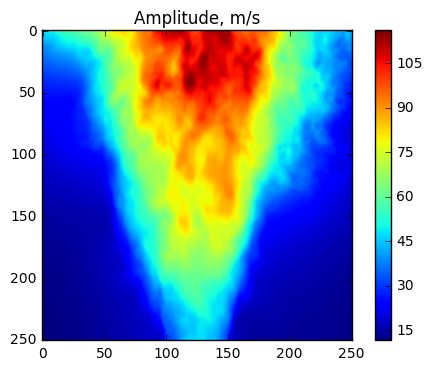

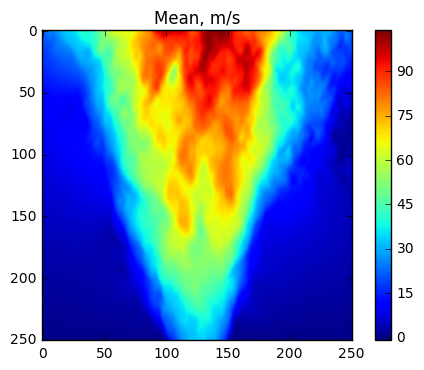

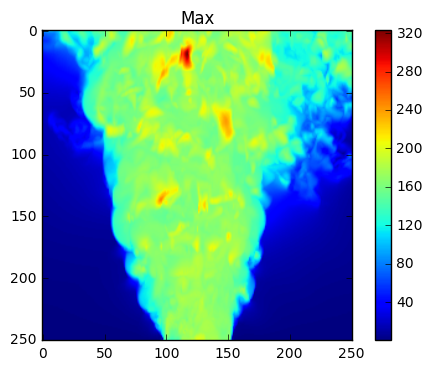

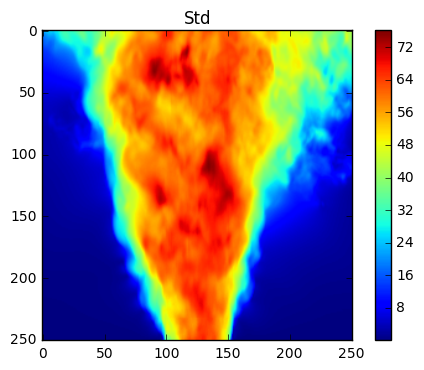

In [35]:
analyze_velocity = True

if analyze_velocity:
    proj_amp = np.mean(amp, axis=0)
    plt.imshow(proj_amp, cmap=cm.jet)
    plt.title('Amplitude, m/s')
    plt.colorbar()
    plt.show()
    
    proj_v = np.mean(-v, axis=0)
    plt.imshow(proj_v, cmap=cm.jet)
    plt.title('Mean, m/s')
    plt.colorbar()
    plt.show()
    
    proj_v = np.max(-v, axis=0)
    plt.title('Max')
    plt.imshow(proj_v, cmap=cm.jet)
    plt.colorbar()
    plt.show()
    
    proj_v = np.std(-v, axis=0)
    plt.title('Std')
    plt.imshow(proj_v, cmap=cm.jet)
    plt.colorbar()

    plt.show()
    
    
    
    
    

In [9]:
is_apply_forward_flow = False

if is_apply_forward_flow:
    
    res = np.zeros_like(vol)

    pad = 0
    res = np.zeros((nz+pad, ny+pad, nx+pad))


    from time import time
    start = time()

    for k in range(0, nz):
        for i in range(0, ny):
            for j in range(0, nx):
                d = vol[k,i,j]

                #print d

                ii_fp = i + v[k,i,j]*vel_factor
                jj_fp = j + u[k,i,j]*vel_factor
                kk_fp = k + w[k,i,j]*vel_factor

                if (ii_fp < 0 or jj_fp < 0 or kk_fp < 0 or ii_fp >= ny-1 or jj_fp >= nx-1 or kk_fp >= nz-1):
                    continue;

                ii = int(math.floor(ii_fp))
                jj = int(math.floor(jj_fp))
                kk = int(math.floor(kk_fp))

                delta_i = ii_fp - ii
                delta_j = jj_fp - jj
                delta_k = kk_fp - kk

                #ii += int(pad  - 0)
                #jj += int(pad / 2 - 0)
                #kk += int(pad / 2 - 0)

                res[kk  ,ii  ,jj  ] += (1.0-delta_k)*(1.0-delta_j)*(1.0-delta_i) * d
                res[kk  ,ii  ,jj+1] += (1.0-delta_k)*(    delta_j)*(1.0-delta_i) * d
                res[kk  ,ii+1,jj  ] += (1.0-delta_k)*(1.0-delta_j)*(    delta_i) * d
                res[kk  ,ii+1,jj+1] += (1.0-delta_k)*(    delta_j)*(    delta_i) * d

                res[kk+1,ii  ,jj  ] += (    delta_k)*(1.0-delta_j)*(1.0-delta_i) * d
                res[kk+1,ii  ,jj+1] += (    delta_k)*(    delta_j)*(1.0-delta_i) * d
                res[kk+1,ii+1,jj  ] += (    delta_k)*(1.0-delta_j)*(    delta_i) * d
                res[kk+1,ii+1,jj+1] += (    delta_k)*(    delta_j)*(    delta_i) * d


                #res[k,i,j] = d


    elapsed = time() - start
    print ("Time : ", elapsed)
                     

In [11]:
if is_apply_forward_flow:
    print()'Diff:', round(np.sum(vol) - np.sum(res), 3) )

SyntaxError: invalid syntax (<ipython-input-11-0f22ec48f70c>, line 2)

In [8]:
if is_apply_forward_flow:
    
    img = Image.fromarray(res[120+pad-0])
    plt.imshow(img, cmap=cm.jet)
    plt.show()

    img.save(path + 'test.tif')

    print vol[120,230,120]
    print np.max(res)

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(vol[120,230,120])? (<ipython-input-8-3e8897fa16cb>, line 9)

In [26]:
is_save_stack = True

if is_apply_forward_flow == False:
    pad = 0
    
if  is_save_stack:
    for z in range(nz+pad):

        img = Image.fromarray(vol[z])
        ensure_dir(path + "\\"+ dataset + "_den\\")
        img.save(path + "\\"+ dataset + "_den\\" + "vol" + str(z).zfill(3) + ".tiff")
        
        img = Image.fromarray(u[z])
        ensure_dir(path + "\\"+ dataset + "_vel_x\\")
        img.save(path + "\\"+ dataset + "_vel_x\\" + "vol" + str(z).zfill(3) + ".tiff")

        img = Image.fromarray(v[z])
        ensure_dir(path + "\\"+ dataset + "_vel_y\\")
        img.save(path + "\\"+ dataset + "_vel_y\\" + "vol" + str(z).zfill(3) + ".tiff")

        img = Image.fromarray(w[z])
        ensure_dir(path + "\\"+ dataset + "_vel_z\\")
        img.save(path + "\\"+ dataset + "_vel_z\\" + "vol" + str(z).zfill(3) + ".tiff")

        img = Image.fromarray(amp[z])
        ensure_dir(path + "\\"+ dataset + "_vel_amp\\")
        img.save(path + "\\"+ dataset + "_vel_amp\\" + "vol" + str(z).zfill(3) + ".tiff")
        
        img = Image.fromarray(liq_mass_frac[z])
        ensure_dir(path + "\\"+ dataset + "_liq_mass_frac\\")
        img.save(path + "\\"+ dataset + "_liq_mass_frac\\" + "vol" + str(z).zfill(3) + ".tiff")
        
        #img = Image.fromarray(res[z])
        #img.save(path + "\\"+ dataset + "_res\\" + "vol" + str(z).zfill(3) + ".tiff")
        img = Image.fromarray(liq_vol_frac[z])
        ensure_dir(path + "\\"+ dataset + "_liq_vol_frac\\")
        img.save(path + "\\"+ dataset + "_liq_vol_frac\\" + "vol" + str(z).zfill(3) + ".tiff")
    print('Finished')


Finished


Finished
